# Introducing pwangbot

I was chatting with @dff of @tidelift at the NumFocus summit last year, and he suggested classifying @pwang's tweets.  For those who don't know, @pwang tweets alot, and the content is quite good - but it spans a variety of subjects.  If you want to hear @pwang tweet about tech, but not about politics, it can be a problem.  So we're going to collect @pwang tweets, do some topic modeling, and then make some bots!

## Topic Modeling of Tweets




In [1]:
%matplotlib inline
import s3fs
import json
import logging
import tweepy
logging.basicConfig(level=logging.INFO)

In [2]:
from string import punctuation
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import casual_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
en_stop = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stoplist = en_stop.union(set(punctuation))
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
fs = s3fs.S3FileSystem()
root = 'saturn-cloud-data/hugo/pwang-bot-data'
paths = fs.ls(root)

In [4]:
data = []
for p in paths:
    with fs.open(p) as f:
        data.append(json.load(f))

## Tokenization

We do the following - convert everything to lower case words, Throwing out "stop" words, optionally throwing out usernames, urls, and then stemming and lemmatizing.  

In [7]:
en_stop.add('http')
en_stop.add('https')
en_stop.add('co')
en_stop.add('rt')
en_stop.add('like')
en_stop.add('first')
en_stop.add('time')
en_stop.add('next')

def tokenize(x, with_usernames=True):
    for token in casual_tokenize(x):
        if "'" in token:
            token = token.split("'")[0]
        token = token.lower()
        token = stemmer.stem(token)
        if token in en_stop:
            continue
        if not with_usernames:
            if "@" in token:
                continue
        if ":" in token:
            continue
        if len(token) > 3:
            yield lemmatizer.lemmatize(token)

texts = [" ".join(list(tokenize(x['text']))) for x in data]
texts_no_username = [" ".join(list(tokenize(x['text'], with_usernames=False))) for x in data]

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

documents = texts_no_username
no_features = 1000

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=en_stop)
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [12]:
# Run LDA
from sklearn.decomposition import LatentDirichletAllocation
no_topics = 2
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=50, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

/srv/conda/envs/saturn/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [13]:
import numpy as np
# results = np.argmax(nmf.transform(tfidf_vectorizer.transform(texts)), axis=1)
results = np.argmax(lda.transform(tf_vectorizer.transform(texts)), axis=1)

In [14]:
categorized = {'raw': {}, 'token_no_username': {}, 'token': {}}
for idx, result in enumerate(results):
    categorized['token_no_username'].setdefault(result, []).append(texts_no_username[idx])
    categorized['token'].setdefault(result, []).append(texts[idx])
    categorized['raw'].setdefault(result, []).append(data[idx]['text'])
{len(categorized['raw'][x]) for x in range(no_topics)}

{1563, 1842}

1842


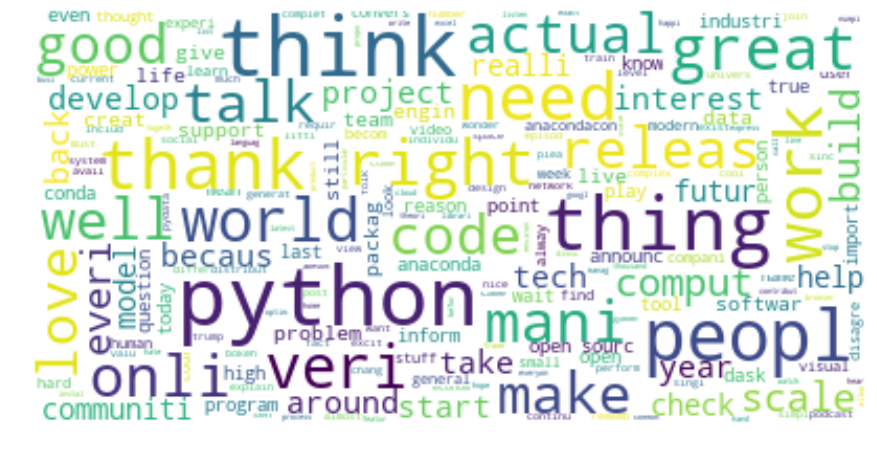

1563


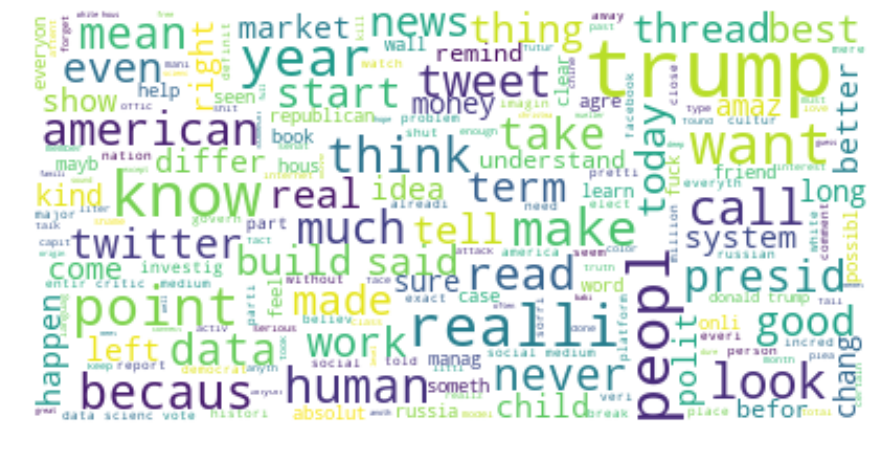

In [15]:
import os

from os import path
from wordcloud import WordCloud

# Generate a word cloud image
for c in range(no_topics):
    print(len(categorized['token_no_username'][c]))
    text = " ".join(categorized['token_no_username'][c])
    import matplotlib.pyplot as plt
    # lower max_font_size
    wordcloud = WordCloud(background_color="white", max_font_size=40).generate(text)
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()


In [16]:
accounts = ['pwangbot_tech', "pwangbot_politics"]
with open("/home/jovyan/twitter-creds.json") as f:
    creds = json.load(f)
tapis = []
for a in accounts:
    cred = creds.get(a, None)
    if cred is None:
        tapis.append(None)
        continue
    auth = tweepy.OAuthHandler(cred['consumer_key'], cred['consumer_secret'])
    auth.set_access_token(cred['access_token'], cred['access_token_secret'])
    api = tweepy.API(auth, wait_on_rate_limit=True, timeout=120)
    tapis.append(api)
cred = creds.get('hhhuuugggooo', None)
auth = tweepy.OAuthHandler(cred['consumer_key'], cred['consumer_secret'])
auth.set_access_token(cred['access_token'], cred['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True, timeout=120)


In [40]:
max_id

1113884718645350402

In [ ]:
# max_id = 0
import time
while True:
    time.sleep(600)
    new_tweets = tapis[0].user_timeline('pwang')
    new_tweets = [x._json for x in new_tweets if x.id > max_id]
    print ('%s new tweets', len(new_tweets))
    if len(new_tweets) == 0:
        continue
    new_tweets = sorted(new_tweets, key=lambda x: x['id'])
    # new_tweets = data
    texts = []
    for tweet in new_tweets:
        text_no_username = " ".join(list(tokenize(tweet['text'], with_usernames=False)))
        texts.append(text_no_username)    
    results = np.argmax(lda.transform(tf_vectorizer.transform(texts)), axis=1)
    for r, tweet in zip(results, new_tweets):
        account = accounts[r]
        api = tapis[r]
        print('tweeting %s to %s' % (tweet['text'], account))
        if api is not None:
            api.retweet(tweet['id'])
    max_id = max([x['id'] for x in new_tweets])
    

%s new tweets 0
%s new tweets 0
%s new tweets 1
tweeting RT @ixek: Analysing @pwang tweets at #AnacondaCON https://t.co/49wNdliace to pwangbot_tech


In [45]:
max_id

1114138031441809410